In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import timeit
import seaborn as sns
import scipy.stats as stats

### Cumulative Advantage

For each (filtered) cohort analyze how the distribution of publications changes in the cohort over time.
At the beginning all scientists should be equal (they have zero publications). Over time some scientists become more successful than others which leads to an increase in the Gini coefficient.

In [2]:
start_time = timeit.default_timer()
print(start_time)

1.1842625715393282e-06


In [3]:
gender = pd.read_csv('./data/name_gender_1970_2016_noAsians.csv')
gender.rename(columns={'name':'author'},inplace=True)
print(gender.head())
print(gender['gender'].unique())
print(gender['author'].nunique())

# some names occur multiple times, but the gender assignment should be the same.
#counts = gender.groupby('author').size()
#df2 = pd.DataFrame(counts, columns = ['size'])
#print(df2.head())
#print(df2[df2['size'] > 1])

             author gender
0    nima mesgarani      m
1    james j. abbas      m
2  eberhart zrenner      m
3    emery n. brown      m
4        ilya rybak      m
['m' 'none' 'f']
1129473


In [4]:
max_years = 15
#authorStartEndCareerData = pd.read_csv('data/authors-scientific-start-end-year-publish-count.csv')
authorStartEndCareerData = pd.read_csv('./data/authors-scientific-atleast-15-year.csv')
#authorStartEndCareerData = pd.read_csv('data/authors-scientific-atleast-20-year-20-papers.csv')
print(authorStartEndCareerData.head())
print("authorStartEndCareerData  %s", authorStartEndCareerData.shape[0])
print("author unique names  %s", authorStartEndCareerData['author'].nunique())
print(authorStartEndCareerData[authorStartEndCareerData['author']=='a min tjoa'])
print(authorStartEndCareerData.describe())

               author  start_year  end_year  pub_count  career_length
0          a min tjoa        1979      2015        193             36
1    a-imam al-sammak        1992      2008          6             16
2          a-xing zhu        1998      2015         16             17
3  a. a. (louis) beex        1980      2016         34             36
4     a. a. a. nasser        1993      2014          3             21
authorStartEndCareerData  %s 110468
author unique names  %s 110468
       author  start_year  end_year  pub_count  career_length
0  a min tjoa        1979      2015        193             36
          start_year       end_year      pub_count  career_length
count  110468.000000  110468.000000  110468.000000  110468.000000
mean     1991.428577    2012.895083      32.668338      21.466506
std         7.297041       4.405741      48.993761       6.089202
min      1970.000000    1985.000000       2.000000      15.000000
25%      1988.000000    2012.000000       7.000000      17.

In [5]:
authorStartEndCareerData = pd.merge(authorStartEndCareerData, gender, how="left", on=["author"])
authorStartEndCareerData['gender'] = authorStartEndCareerData['gender'].fillna('none')

print(authorStartEndCareerData.head())
print(authorStartEndCareerData.describe())

             author  start_year  end_year  pub_count  career_length gender
0        a min tjoa        1979      2015        193             36   none
1  a-imam al-sammak        1992      2008          6             16      m
2  a-imam al-sammak        1992      2008          6             16      m
3  a-imam al-sammak        1992      2008          6             16      m
4  a-imam al-sammak        1992      2008          6             16      m
         start_year      end_year     pub_count  career_length
count  2.365914e+06  2.365914e+06  2.365914e+06   2.365914e+06
mean   1.990932e+03  2.014577e+03  9.068298e+01   2.364505e+01
std    7.328825e+00  2.756475e+00  9.495941e+01   6.942496e+00
min    1.970000e+03  1.985000e+03  2.000000e+00   1.500000e+01
25%    1.987000e+03  2.015000e+03  2.900000e+01   1.800000e+01
50%    1.992000e+03  2.015000e+03  6.200000e+01   2.200000e+01
75%    1.997000e+03  2.016000e+03  1.170000e+02   2.800000e+01
max    2.001000e+03  2.016000e+03  1.199000e+0

authorStartEndCareerData no duplicates: %s 110468
110468
110468


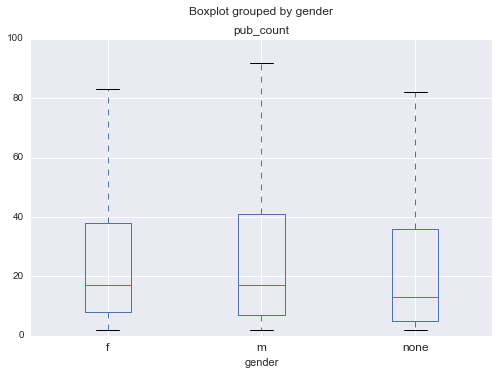

In [6]:

# there are no duplicates
authorStartEndCareerData = authorStartEndCareerData.drop_duplicates()
print("authorStartEndCareerData no duplicates: %s", authorStartEndCareerData.shape[0])
print(authorStartEndCareerData['author'].nunique())

test = authorStartEndCareerData[["pub_count", "gender"]]
print(test.shape[0])

#print(test.head())
#print(authorStartEndCareerData[["start_year", "gender", "pub_count"]].groupby(['start_year', 'gender']).agg({'count', 'mean', 'std'}))
authorStartEndCareerData.boxplot(column='pub_count', by='gender', showfliers=False)

In [7]:

selectedAuthor = authorStartEndCareerData["author"].unique()
print(len(selectedAuthor))

authorPublicationsData = pd.read_csv('data/author_publications_1970_2016_asiansAsNone.txt')
authorPublicationsData = authorPublicationsData[authorPublicationsData["year"] > 1900]
print(authorPublicationsData.head(n=1))

print("authorPublicationsData")
print(authorPublicationsData['author'].nunique())
#print(authorPublicationsData.index)
print(authorPublicationsData.shape[0])



# contains only authors-scientific-atleast-15-year --> we filter authorPublicationsData that only those authors are inlcuded

print("authorStartEndCareerData")
print(authorStartEndCareerData['author'].nunique())
#print(authorStartEndCareerData.index)
print(authorStartEndCareerData.shape[0])

#authorPublicationsData = pd.merge(authorPublicationsData, authorStartEndCareerData,  how="left", left_on="author", right_on="author")


#authorPublicationsData = authorPublicationsData.dropna(how='any')
#print(authorPublicationsData.head(n=2))
#print(authorPublicationsData['author'].nunique())
#print(authorPublicationsData.shape[0])


#get the year list - as it helps to enumerate and find gini co-efficient for each year (irrespective of the dataset)
#years = np.sort(authorPublicationsData['year'].unique())
#print(years)

110468
             author  year                    pub_id
0  kim l. blackwell  2014  55503da645ce0a409eb273e8
authorPublicationsData
1702516
9016289
authorStartEndCareerData
110468
110468


In [8]:
print(authorPublicationsData.head(n=3))

             author  year                    pub_id
0  kim l. blackwell  2014  55503da645ce0a409eb273e8
1    nima mesgarani  2014  55503da645ce0a409eb273e9
2    james j. abbas  2014  55503da645ce0a409eb273ea


In [9]:


#groupByStartYearScientificCareerData = authorStartEndCareerData[['author','start_year']].groupby(['start_year'])
#print(groupByStartYearScientificCareerData.head())
#groupByStartYearScientificCareerData.groups

In [ ]:
#Group by both year and author - multi index and hierarchial indexing
#authorPublicationsData

print(authorPublicationsData[authorPublicationsData.author=="a min tjoa"].head(n=5))

groupByAuthorYearData = authorPublicationsData.groupby(['year','author']).count().reset_index()
#remove wrong data
groupByAuthorYearData = groupByAuthorYearData[groupByAuthorYearData["year"] > 1900]
print(groupByAuthorYearData.head())

print(groupByAuthorYearData[groupByAuthorYearData.author=="a min tjoa"].head(n=5))


           author  year                    pub_id
47504  a min tjoa  2004  53e9ac96b7602d9703671ea0
81537  a min tjoa  2008  53e9b403b7602d9703ef2cf3
81583  a min tjoa  2007  53e9aad9b7602d970345a7fb
81770  a min tjoa  2013  53e9b783b7602d9704329922
81790  a min tjoa  2003  53e9ae29b7602d970383a84d
   year         author  pub_id
0  1970    a. a. afifi       1
1  1970    a. a. bährs       1
2  1970     a. armenti       1
3  1970  a. b. slomson       1
4  1970    a. brindley       1
        year      author  pub_id
33440   1979  a min tjoa       1
85309   1985  a min tjoa       1
97531   1986  a min tjoa       1
174683  1990  a min tjoa       1
202845  1991  a min tjoa       3


In [ ]:
#Group by both year and author - multi index and hierarchial indexing
groupByAuthorYearData = authorPublicationsData.groupby(['year','author']).count().reset_index()
#remove wrong data
groupByAuthorYearData = groupByAuthorYearData[groupByAuthorYearData["year"] > 1900]
print(groupByAuthorYearData.head())


print(groupByAuthorYearData[groupByAuthorYearData.author=="a min tjoa"])

# cumulative number of publications per author
groupByAuthorYearData = groupByAuthorYearData.set_index('year').sort_index()
#print(groupByAuthorYearData.head())

groupByAuthorYearData["cum_num_pub"] = groupByAuthorYearData.groupby(['author'])['pub_id'].transform(pd.Series.cumsum)
groupByAuthorYearData = groupByAuthorYearData.reset_index()
print(groupByAuthorYearData.head())




groupByAuthorYearData = pd.merge(groupByAuthorYearData, authorStartEndCareerData,  how="left", left_on="author", right_on="author")

groupByAuthorYearData = groupByAuthorYearData.dropna(how='any')
print(groupByAuthorYearData.head(n=2))
print(groupByAuthorYearData['author'].nunique())
print(groupByAuthorYearData.shape[0])

print(groupByAuthorYearData.head())
print(groupByAuthorYearData[groupByAuthorYearData.author=="a min tjoa"])


groupByAuthorYearData = groupByAuthorYearData.reset_index()
print(groupByAuthorYearData.head())


   year         author  pub_id
0  1970    a. a. afifi       1
1  1970    a. a. bährs       1
2  1970     a. armenti       1
3  1970  a. b. slomson       1
4  1970    a. brindley       1
         year      author  pub_id
33440    1979  a min tjoa       1
85309    1985  a min tjoa       1
97531    1986  a min tjoa       1
174683   1990  a min tjoa       1
202845   1991  a min tjoa       3
234843   1992  a min tjoa       3
272007   1993  a min tjoa       6
317066   1994  a min tjoa       2
368210   1995  a min tjoa       3
422874   1996  a min tjoa       5
481284   1997  a min tjoa       2
547478   1998  a min tjoa       3
704036   2000  a min tjoa       8
797455   2001  a min tjoa       5
901041   2002  a min tjoa       3
1016521  2003  a min tjoa      11
1155821  2004  a min tjoa       8
1320619  2005  a min tjoa      13
1512468  2006  a min tjoa      23
1725677  2007  a min tjoa      13
1962106  2008  a min tjoa       8
2219974  2009  a min tjoa       8
2500825  2010  a min tjoa      1

In [ ]:
#the following snippet is taken from the github project and the license is creative commons
#https://github.com/oliviaguest/gini

def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    array = array.flatten()
    if np.min(array) < 0:
        # Values cannot be negative:
        array -= np.min(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

### To check whether GINI calculation works correctly or not

In [ ]:
#print(gini[1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
#print(gini(range(10)))

In [ ]:
def plot_gender_numcumpub2(ax, cohort_duration, selected_cumnumpub_df, year):   
    #ax.errorbar(cohort_duration, selected_cumnumpub_df["mean_f"].values,  yerr=selected_cumnumpub_df["sem_f"].values, label='women', color="red" )
    #ax.errorbar(cohort_duration, selected_cumnumpub_df["mean_m"].values,  yerr=selected_cumnumpub_df["sem_m"].values, label='men', color="blue")
    #ax.errorbar(cohort_duration, selected_cumnumpub_df["mean_n"].values,  yerr=selected_cumnumpub_df["sem_n"].values, label='unknown', color="grey")
   
    ax.plot(cohort_duration, selected_cumnumpub_df["mean_f"].values,  label='women', color="red")
    ax.fill_between(cohort_duration, selected_cumnumpub_df["mean_f"].values-selected_cumnumpub_df["sem_f"].values, 
                     selected_cumnumpub_df["mean_f"].values+selected_cumnumpub_df["sem_f"].values,
    alpha=0.2, edgecolor='red', facecolor='red',
    linewidth=4, linestyle='dashdot', antialiased=True)
    
    #ax.set_title("Cohort start-year: "+str(year))
    
    return sep



# plot num cum publication stats
def plot_gender_numcumpub(ax, cohort_duration, selected_cumnumpub_df, year):
    ax.plot(cohort_duration, selected_cumnumpub_df["mean_f"].values,  label='women', color="red")
    ax.fill_between(cohort_duration, selected_cumnumpub_df["mean_f"].values-selected_cumnumpub_df["sem_f"].values, 
                     selected_cumnumpub_df["mean_f"].values+selected_cumnumpub_df["sem_f"].values,
    alpha=0.2, edgecolor='red', facecolor='red',
    linewidth=4, linestyle='dashdot', antialiased=True)
    
    ax.plot(cohort_duration, selected_cumnumpub_df["mean_m"].values,  label='men', color="blue")
    ax.fill_between(cohort_duration, selected_cumnumpub_df["mean_m"].values-selected_cumnumpub_df["sem_m"].values, 
                     selected_cumnumpub_df["mean_m"].values+selected_cumnumpub_df["sem_m"].values,
    alpha=0.2, edgecolor='blue', facecolor='blue',
    linewidth=4, linestyle='dashdot', antialiased=True)

    ax.plot(cohort_duration, selected_cumnumpub_df["mean_n"].values,  label='unknown', color="grey")
    ax.fill_between(cohort_duration, selected_cumnumpub_df["mean_n"].values-selected_cumnumpub_df["sem_n"].values, 
                     selected_cumnumpub_df["mean_n"].values+selected_cumnumpub_df["sem_n"].values,
    alpha=0.2, edgecolor='grey', facecolor='grey',
    linewidth=4, linestyle='dashdot', antialiased=True)
    
    #ax.errorbar(cohort_duration, selected_cumnumpub_df["mean_f"].values,  yerr=selected_cumnumpub_df["sem_f"].values, label='women', color="red" )
    #ax.errorbar(cohort_duration, selected_cumnumpub_df["mean_m"].values,  yerr=selected_cumnumpub_df["sem_m"].values, label='men', color="blue")
    #ax.errorbar(cohort_duration, selected_cumnumpub_df["mean_n"].values,  yerr=selected_cumnumpub_df["sem_n"].values, label='unknown', color="grey")
   
  
    return ax



    
  

   

    # Make one Bar Chart per COHORT
    #fig, ax = plt.subplots()
    #width = 0.3       # the width of the bars
    #Y = len(gini_years)
    #ind = np.arange(Y)
    #ax.set_title('Inequality for cohort: '+str(year))
    #rects = ax.bar(ind, gini_coefs, width, color='b')
    #ax.set_xticks(ind + width / 2)
    #ax.set_xticklabels(gini_years, rotation=90)
    #ax.set_ylabel('Gini')
    #plt.show()
    

### Num-publication distribution of each cohort in each year

* We compute the gini coefficient for each cohort in each year separately based on the cumulative number of publications that this group has aggregated. 
* We compute the mean and std of the cumulative number of publications for men and women in each cohort separately.


In [ ]:
print(authorStartEndCareerData.head(n=1))
gini_per_cohort = pd.DataFrame(index=years)
cumnumpub_per_cohort = pd.DataFrame(index=years)


#fig2, ax2 = plt.subplots()
fig2 = plt.figure()
ax2 = fig2.add_subplot(1,1,1)
fig3 = plt.figure()
ax3 = fig3.add_subplot(1,1,1)


max_years = 15
# limit plot to the N years during which we follow a cohort
cohort_duration = np.arange(max_years)

# 30 years
fig5 = plt.figure(figsize=(40,20))

i=1

for year in years: #[1975,1980,1985, 1990]: #
    #we cannot follow the cohort for max years; for 2016 we do not have enough data
    if year > (2015 - max_years):
        break
    
    ax5 = fig5.add_subplot(6, 6, i)
    i = i+1
    
    fig4 = plt.figure()
    ax4 = fig4.add_subplot(1, 1, 1)

    #print("cohort: "+str(year))
    cohort = authorStartEndCareerData[authorStartEndCareerData["start_year"]==year]
    cohort_authors = cohort["author"].values
  
    gini_over_years = pd.Series(data=0, index=years)
    cumnumpub_over_years = pd.DataFrame(data=0, index=years, columns=["mean", "std", "mean_f", "std_f", "mean_m", "std_m", "mean_n", "std_n"])
 
    # extract num publications for the cohort in all future years
    for y in range(year, max(years)+1):
        #print("following years: "+str(y))
      
        # get all the authors data for each year and filter based on the authors that we are interested in
        temp = groupByAuthorYearData[groupByAuthorYearData["year"]==y]
        temp = temp[temp["author"].isin(cohort_authors)]
        
        # gini per year based on cumulative num of publications of all authors in this year
        gini_over_years.loc[y] = gini(temp['cum_num_pub'].astype("float").values)
        
        temp_male = temp[temp["gender"]=="m"]
        temp_female = temp[temp["gender"]=="f"]
        temp_none = temp[temp["gender"]=="none"]
        
        cumnumpub_over_years.loc[y] = [np.mean(temp['cum_num_pub'].astype("float").values), 
                                       np.std(temp['cum_num_pub'].astype("float").values),
                                       np.mean(temp_female['cum_num_pub'].astype("float").values), 
                                       stats.sem(temp_female['cum_num_pub'].astype("float").values),
                                       np.mean(temp_male['cum_num_pub'].astype("float").values), 
                                       stats.sem(temp_male['cum_num_pub'].astype("float").values),
                                       np.mean(temp_none['cum_num_pub'].astype("float").values), 
                                       stats.sem(temp_none['cum_num_pub'].astype("float").values)]
        
    
   
    gini_years_df = pd.DataFrame(gini_over_years.reset_index())
    gini_years_df.columns = ["year", "gini"]
    #gini_per_cohort[year] = gini_years_df
   
    gini_years = gini_years_df["year"].values
    gini_coefs= gini_years_df["gini"].values
    selected_gini_df = gini_years_df[(gini_years_df["year"] >= year) &  (gini_years_df["year"] < (year+max_years))]
    ax2.plot(cohort_duration, selected_gini_df["gini"])
   
    #["mean", "std", "mean_f", "std_f", "mean_m", "std_m", "mean_n", "std_n"])
    cumnumpub_years_df = pd.DataFrame(cumnumpub_over_years.reset_index())
    cumnumpub_years_df.columns = ["year", "mean", "std", "mean_f", "sem_f", "mean_m", "sem_m", "mean_n", "sem_n"]
    #cumnumpub_per_cohort[year] = cumnumpub_years_df
   
    selected_cumnumpub_df = cumnumpub_years_df[(cumnumpub_years_df["year"] >= year) &  (cumnumpub_years_df["year"] < (year+max_years))]
    ax3.errorbar(cohort_duration, selected_cumnumpub_df["mean"].values,  yerr=selected_cumnumpub_df["std"].values)
    
    
    ax4 = plot_gender_numcumpub(ax4, cohort_duration, selected_cumnumpub_df, year)
    ax4.set_title("Cohort start-year: "+str(year))  
    ax4.set_ylabel('Cumulative Publication Count')
    ax4.legend()
    fig4.savefig("fig/cumnumpub_gender_"+str(year)+".png")
    
    ax5 = plot_gender_numcumpub(ax5, cohort_duration, selected_cumnumpub_df, year)
    ax5.set_title("Cohort start-year: "+str(year))



ax2.set_ylabel('Gini')
ax2.set_title('Inequality of al cohorts over '+str(max_years)+' years')
if len(years)<10:
    ax2.legend(years)  
fig2.savefig("fig/gini.png")

ax3.set_ylabel('Cumulative Publication Count')
ax3.set_title('Mean/Std of al cohorts over '+str(max_years)+' years')
if len(years)<10:
    ax3.legend(years)  
    
fig3.savefig("fig/cumnumpub.png")

fig5.savefig("fig/cumnumpub_gender.png")
  
plt.show()

   


### Ranking of men and women in this distribution

Num-publication distribution. What is the mean/median rank of men and women. For which cohorts do we find a significant differnce after 10 or 15 years?



In [ ]:
end_time = timeit.default_timer()
print(end_time)
print('Time taken - ',end_time-start_time)

### Stability of Ranking

How stable is the ranking ober time. We expect that at the top the ranking is rather stable.
How much rank-increase do men and women achieve over the years?

